Consider the Hamiltonian,

\begin{eqnarray}
\mathcal{H}(t) = h \cos(\omega t)\hat{\sigma}^z + \Delta \hat{\sigma}^x
\label{eq:exactham}
\end{eqnarray}
Let us consider,

\begin{align}
H_0 &= \Delta \hat{\sigma}^x \\
H_1 &= h \cos(\omega t)\hat{\sigma}^z
\end{align}

We consider rotating frame. 
The unitary evolution operator, $\hat{U}(t) = \exp\big[-i \frac{h}{\omega} \sin(\omega t)\hat{\sigma}^z\big]$.

So the transformed rotating Hamiltonian is,

\begin{align}
\tilde{\mathcal{H}}(t) &=\hat{U}^\dagger(t) \mathcal{H}(t) \hat{U}(t) - i \hat{U}^\dagger(t) \partial_t \hat{U}(t)\\
&= \hat{U}^\dagger(t) H_0 \hat{U}(t)\\
&= e^{i \frac{h}{\omega} \sin(\omega t)\hat{\sigma}^z} \Big(\Delta \hat{\sigma}^x\Big) e^{-i \frac{h}{\omega} \sin(\omega t)\hat{\sigma}^z}\\
\end{align}


Let us consider, $\phi = \frac{2h}{\omega} \sin(\omega t)$ and recalling $\hat{S}^{\mu} = \frac12 \hat{\sigma}^{\mu}$then we can write,
    \begin{align}
    \tilde{\mathcal{H}}(t) &= e^{i \frac{2h}{\omega} \sin(\omega t)\hat{S}^z} \Big(2\Delta \hat{S}^x\Big) e^{-i \frac{2h}{\omega} \sin(\omega t)\hat{S}^z}\nonumber\\
    &= 2\Delta \Big(\hat{S}^x \cos{\phi} - \hat{S}^y \sin{\phi}\Big)\nonumber\\
    &= 2\Delta \Big[\hat{S}^x\cos\Big(\frac{2h}{\omega}\sin(\omega t)\Big) - \hat{S}^y\sin\Big(\frac{2h}{\omega}\sin(\omega t)\Big)\Big]
    \end{align}
    
Using Jacobi Anger expansion,
\begin{equation}
\tilde{\mathcal{H}}(t) = \Delta \Bigg[\hat{\sigma}^x \Big\{\mathcal{J}_0\Big(\frac{2h}{\omega}\Big) + 2 \sum_{n=1}^{\infty} \mathcal{J}_{2n}\Big(\frac{2h}{\omega}\Big)\cos(2n\omega t)\Big\} -\hat{\sigma}^y\Big\{2\sum_{n=1}^{\infty} \mathcal{J}_{2n-1}\Big(\frac{2h}{\omega}\Big) \sin([(2n-1)\omega t])\Big)\Big\}\Bigg]
\label{eq:hexact}
\end{equation}

RWA suggests neglecting the fast oscillating terms, so applying RWA to the above equation we get,

\begin{equation}
\hat{\mathcal{H}}_{_{RWA}} = \Delta \mathcal{J}_0 \Big(\frac{2h}{\omega}\Big) \hat{\sigma}^x
\end{equation}

Compare $\omega \ll 1$ and $\omega \gg 1$ for h~O(1)

Running for w =  0.01


<timed exec>:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<timed exec>:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running for w =  20.0


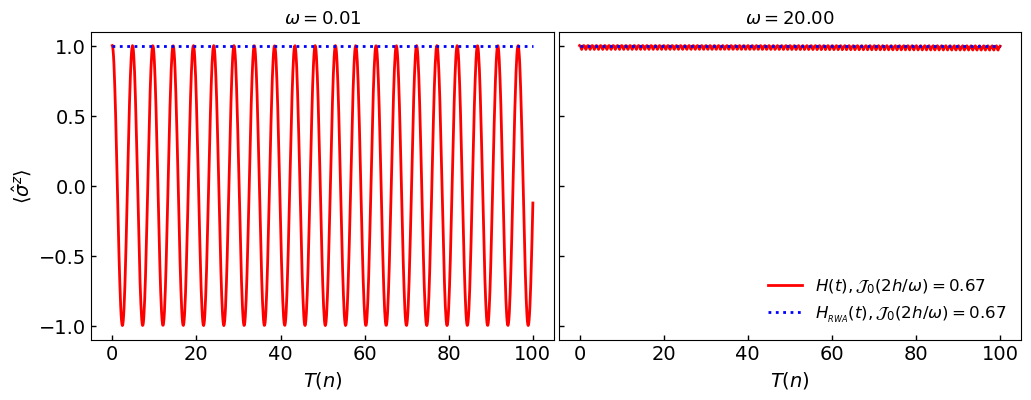

CPU times: user 6.92 s, sys: 14.7 ms, total: 6.93 s
Wall time: 6.91 s


In [11]:
%%time
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import j0, jn_zeros, jv
import numpy as np

plt.rcParams.update({
    "figure.figsize": (12.0, 4),
    "text.usetex": False,
    "font.size": 14})

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def run_dynm_exact(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    H0 = Delta * sx
    H1 = sz
    
    H = [H0,[H1,drive]]

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times

def run_dynm_rwa(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    
    z = 2*h/w
    H = Delta * jv(0, z) * sx

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times


if __name__ == '__main__':
    
    freezing_pts = jn_zeros(0, 5)
    sx, sz = sigmax(), sigmaz()
    
    Delta = 1.0
    ws = [0.01, 20.0]
    nt = 100
    steps = 1000
    
    fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
    plt.subplots_adjust(wspace=0.01, hspace=0.0)
    
    for p, w in enumerate(ws): 
        print(r"Running for w = ", w)
        T = 2*np.pi/w
        h = w/2 * freezing_pts[0]  

        data_exact = np.array(run_dynm_exact(h,w,Delta, nt, steps))
        data_rwa = np.array(run_dynm_rwa(h,w,Delta, nt, steps))

        lbl11 = r"$H(t), \mathcal{{J}}_0(2h/\omega) =$"
        lbl12 = fr"${jv(0,h/w):1.2f}$"
        lbl1 = lbl11 + lbl12
        
        lbl21 = fr"$H_{{_{{RWA}}}}(t), \mathcal{{J}}_0(2h/\omega) =$"
        lbl22 = fr"${jv(0,h/w):1.2f}$"
        lbl2 = lbl21 + lbl22

        lbl = [lbl1,lbl2]

        times = data_exact[1]
        axs[p].plot(times/T,data_exact[0][0], label=lbl[0], linewidth =2, color = 'red')


        axs[p].set_xlabel(r"$T(n)$")
        axs[0].set_ylabel(r"$\langle \hat{\sigma}^z\rangle$")
        axs[p].tick_params(which='both', axis="x", direction="in", width= 1.0)
        axs[p].tick_params(which='both', axis="y", direction="in", width= 1.0)
        
        times = data_rwa[1]
        axs[p].plot(times/T,data_rwa[0][0], label=lbl[1], linewidth =2, linestyle ='dotted', color = 'blue')

        #plt.title(r'$S_x$ Dynamics_TSS: $\omega$=90 Spin =  $%4d$'%N)
        axs[p].set_xlabel(r"$T(n)$")
        #axs[1].set_ylabel(r"$\langle S_x\rangle$")
        axs[p].tick_params(which='both', axis="x", direction="in", width= 1.0)
        axs[p].tick_params(which='both', axis="y", direction="in", width= 1.0)
        
        axs[1].legend(loc = 4, frameon=False, fontsize =12)
        
        axs[p].set_title(fr"$\omega = {w:1.2f}$", fontsize = 13)
    #plt.ylim(0,1.1)
    
    figname = "rwa_vs_exact_w_low_n_high.pdf"
    plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
    
    plt.show()

Running for w =  0.05
Running for w =  1
Running for w =  5
Running for w =  20.0
Running for w =  0.05


Running for w =  1
Running for w =  5
Running for w =  20.0


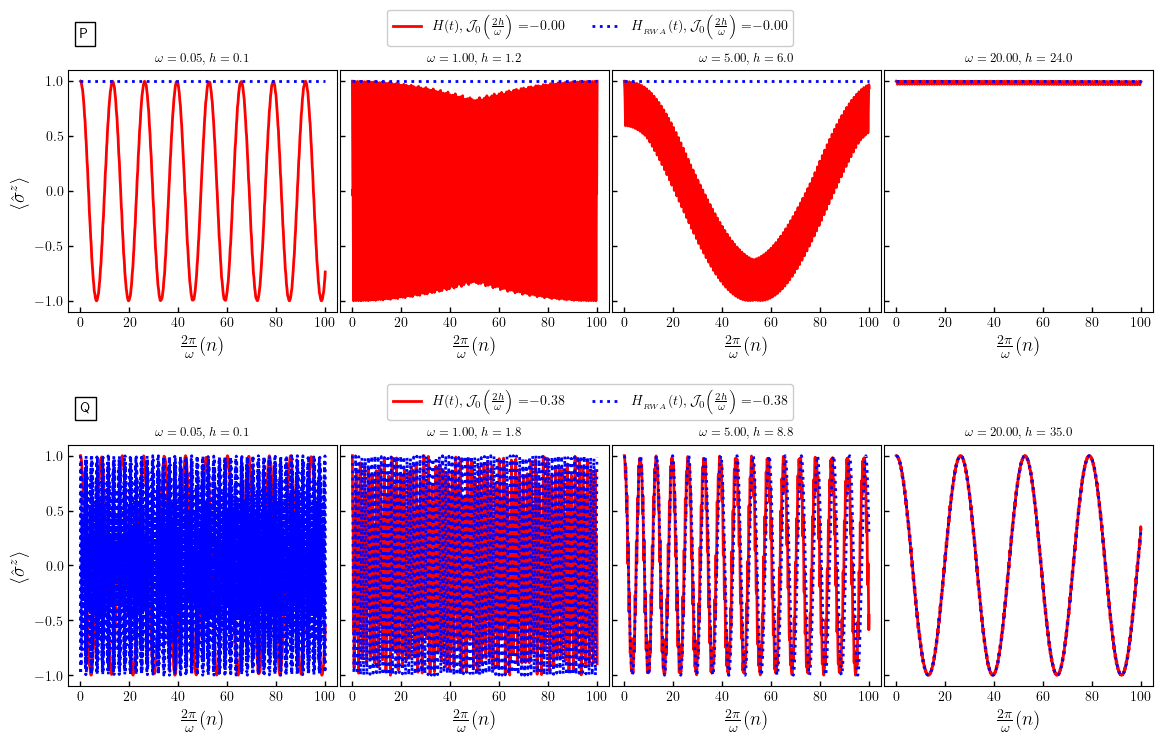

CPU times: user 9.95 s, sys: 91.3 ms, total: 10 s
Wall time: 10 s


In [21]:
%%time
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import j0, jn_zeros, jv
import numpy as np

# Importing warnings
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"figure.figsize": (14, 8),"text.usetex": True,"font.size": 10})

def drive(t, args):
    h = args['h']
    w = args['omega']
    return h * np.cos(w * t)

def run_dynm_exact(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    H0 = Delta * sx
    H1 = sz
    
    H = [H0,[H1,drive]]

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times

def run_dynm_rwa(h, w, Delta, nt, steps):
    params = {'h':h, 'omega':w, 'Delta':Delta} 
    T = 2 * np.pi/w
    times = np.linspace(0, nt * T, steps)
    
    z = 2 * h/w
    H = Delta * jv(0, z) * sx

    en, st = sz.eigenstates()
    a = np.where(np.isclose(en, max(en)))   # Find ground state energy level number
    grket = st[a[0][0]]
    
    out = mesolve(H, grket, times, [], [sz], args = params)
    
    return out.expect, times


if __name__ == '__main__':
    
    freezing_pts = jn_zeros(0, 5)
    sx, sz = sigmax(), sigmaz()
    
    Delta = 1
    ws = [0.05, 1,5,20.0]
    nt = 100
    steps = 1000
    
    frs = [freezing_pts[0], 3.5]
    
    fig, axs = plt.subplots(2, 4, sharey=True, sharex=False)
    plt.subplots_adjust(wspace=0.01, hspace=0.55)
    
    for q, fr in enumerate(frs):
        for p, w in enumerate(ws): 
            print(r"Running for w = ", w)
            T = 2*np.pi/w
            h = w/2 * fr    

            data_exact = np.array(run_dynm_exact(h,w,Delta, nt, steps))
            data_rwa = np.array(run_dynm_rwa(h,w,Delta, nt, steps))

            lbl11 = r"$ H (t), \mathcal{{J}}_0\Big(\frac{{2h}}{{\omega}}\Big) =$"
            lbl12 = fr"${jv(0,fr):1.2f}$"

            lbl1 = lbl11 + lbl12
            lbl21 = fr"$H_{{_{{RWA}}}}(t), \mathcal{{J}}_0\Big(\frac{{2h}}{{\omega}}\Big) =$"
            lbl22 = fr"${jv(0,fr):1.2f}$"
            lbl2 = lbl21 + lbl22

            lbl = [lbl1,lbl2]

            times = data_exact[1]
            axs[q][p].plot(times/T,data_exact[0][0], label=lbl[0], linewidth =2, color = 'red')


            axs[q][p].set_xlabel(r"$T(n)$")
            axs[q][0].set_ylabel(r"$\langle \hat{\sigma}^z\rangle$", fontsize=14)
            axs[q][p].tick_params(which='both', axis="x", direction="in", width= 1.0)
            axs[q][p].tick_params(which='both', axis="y", direction="in", width= 1.0)

            times = data_rwa[1]
            axs[q][p].plot(times/T,data_rwa[0][0], label=lbl[1], linewidth =2, linestyle ='dotted', color = 'blue')

            #plt.title(r'$S_x$ Dynamics_TSS: $\omega$=90 Spin =  $%4d$'%N)
            axs[q][p].set_xlabel(r"$\frac{2\pi}{\omega}(n)$", fontsize=14)
            #axs[1].set_ylabel(r"$\langle S_x\rangle$")
            axs[q][p].tick_params(which='both', axis="x", direction="in", width= 1.0)
            axs[q][p].tick_params(which='both', axis="y", direction="in", width= 1.0)

            axs[q][1].legend(bbox_to_anchor=(0.15, 1.28), loc='upper left',\
                             frameon = True, fontsize = 10,ncol=2, fancybox=True,framealpha=True)
            axs[q][p].set_title(fr"$\omega = {w:1.2f}, h = {h:1.1f}$", fontsize = 9)
            
        #plt.ylim(0,1.1)
    axs[0][0].text(0.0, 1.4, 'P', color='black', bbox=dict(facecolor='none', edgecolor='black'), fontsize=10)
    axs[1][0].text(0.0, 1.4, 'Q', color='black', bbox=dict(facecolor='none', edgecolor='black'), fontsize=10)
    
    figname = "rwa_vs_exact_w_low_n_high_frz_nfrz.pdf"
    plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
    #plt.ylim(-1.1,1.1)
    plt.show()

### Do it for out chimera DMBL Hamiltonian for $\hat{H}_2$

In [7]:
from qutip import *
from scipy import signal
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool

##--- Energy per spin for interaction range order---------
def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

##-- Drive-------------------------------------------------

def drive1(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive2(t, args):
    w = args['omega']
    T = 2 * np.pi/w

    sqr1 = -signal.square(2 * np.pi/T * t)
    if sqr1 == -1:
        sqr1= 0
    return sqr1

def drive3(t, args):    # square cos wave transverse
    w = args['omega']
    h0 = args['h0']
    h = args['h']
    T = 2 * np.pi/w

    sint = -np.sin(w*t)
    if sint<=0:
        sint = 0
    sqrsin = h0 + h * sint
    return sqrsin

def get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H10, H11, H12, H21, H22, H23, H24 =  empt, empt, empt, empt, empt, empt, empt
    
    ##-- Hamiltonian ------------------------------------------- 
    ##-- First half

    for i in range(N1):  
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-ea)

    for i in range(N1,N):  
        id = qeye(2**i)    
        dim12 = N-1-i
        id1 = qeye(2**dim12)
        H12 = H12 + Qobj(tensor(id,tensor(sx,id1)).full()) * g * (1-eb)   

    ##-- Second half

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sy, tensor(id1, tensor(sy,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H22 = H22 + Qobj(tensor(id,tensor(sz,id1)).full()) 

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H23 = H23 + Qobj(tensor(id,tensor(sx,id1)).full()) * lambd_x

    for i in range(N):  
        id = qeye(2**i)    
        dim22 = N-1-i
        id1 = qeye(2**dim22)
        H24 = H24 + Qobj(tensor(id,tensor(sy,id1)).full()) * lambd_y
    
    return H11, H12, H21, H22, H23, H24

##-- Dynamics
def run_exact(args):
    N,N1,lambd_x,lambd_y,Jvalue=args['N'],args['N1'],args['lambd_x'],args['lambd_y'],args['Jvalue']
    beta,g,ea,eb,w = args['beta'],args['g'],args['ea'],args['eb'],args['omega']
    h0,h,times,opts,sz_o = args['h0'],args['h'],args['times'],args['opts'], args['sz_o']
    
    H11, H12, H21, H22, H23, H24 =  get_hamiltonian(N,N1, lambd_x, lambd_y, Jvalue, beta, g, ea, eb)
    
    params = args
    
    H = [[H11,drive1],[H12,drive1],[H23, drive1],[H24, drive1], [H21,drive2], [H22,drive3], [H23,drive2], [H24,drive2]]
    grket = basis(2**N,0)  
    out = mesolve(H, grket, times, [], [sz_o], args = params)
    return out.expect

print("Function definition complete!!")

Function definition complete!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1793.20it/s]


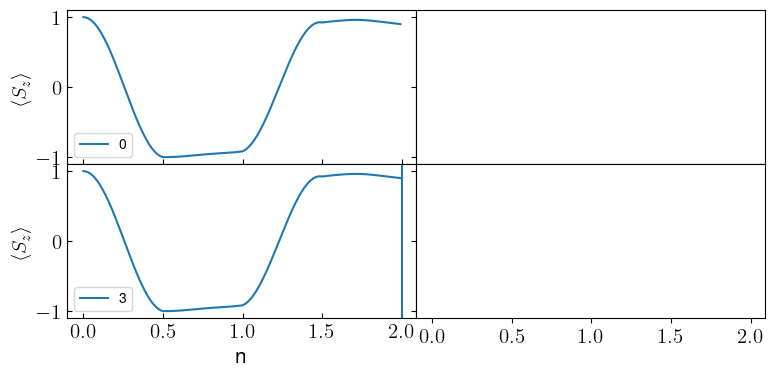

In [34]:
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

#from functions import *

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (9, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
N1= int(N/2)
N2= N-N1
omega = 20.0
w = omega
T = 2 * np.pi/w
times = np.linspace(0,2  * T, 200, endpoint=False)

ea, eb = 0.03, 0.9

lamb = 0.0
lambd_x = lamb
lambd_y = lamb

ft = 10    # fintsize
g = np.pi/T
Jvalue = 0.2/T     # finite interaction strong coupling
#Jvalue = 0.072/T     # finite interaction weak coupling
#Jvalue = 0.0       # infinite interaction
beta = 0.0

nprocs = 2
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e6, num_cpus=1, openmp_threads=1)

#spinposition_A = [0,1,2]
#spinposition_B = [3,4,5] 

spinposition_A = [0]
spinposition_B = [3]

h0 = 0.0
h = freezing_pts[0] * w/4 

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
sx,sy,sz = sigmax(), sigmay(), sigmaz()

sz_os = [] 
for m,i in enumerate(spinposition_A):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_os.append(Qobj(tensor(id,tensor(sz,id1)).full()))

params = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_o':sz_o, 'lambd_x':lambd_x,\
           'lambd_y':lambd_y, 'Jvalue':Jvalue,'beta':beta,\
           'g':g,'ea':ea,'eb':eb, 'times':times} for sz_o in sz_os]

data = p.map(run_exact,tqdm(params, position=0, leave=True))


for m,i in enumerate(spinposition_A):
    axs[0][m].plot(times/T,data[m][0], label = i)
    #axs[0][m].set_xlabel("t")
    #axs[0][m].set_ylabel(r"$\langle S_z \rangle$")
    
    axs[0][m].tick_params(axis="x", direction="in")
    axs[0][m].tick_params(axis="y", direction="in")
    axs[0][m].legend(fontsize=ft)
axs[0][0].set_ylabel(r"$\langle S_z \rangle$")


sz_os = [] 
for m,i in enumerate(spinposition_B):
    id = qeye(2**i)    
    dim12 = N-1-i
    id1 = qeye(2**dim12)
    sz_os.append(Qobj(tensor(id,tensor(sz,id1)).full()))

params = [{'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
           'opts':opts, 'sz_o':sz_o, 'lambd_x':lambd_x,\
           'lambd_y':lambd_y, 'Jvalue':Jvalue,'beta':beta,\
           'g':g,'ea':ea,'eb':eb, 'times':times} for sz_o in sz_os]

data = p.map(run_exact,tqdm(params, position=0, leave=True))
for m,i in enumerate(spinposition_B):
    axs[1][m].plot(times/T,data[m][0], label = i)
    axs[1][m].set_xlabel("n")
    #axs[1][m].set_ylabel(r"$\langle S_z \rangle$")
    
    axs[1][m].tick_params(axis="x", direction="in")
    axs[1][m].tick_params(axis="y", direction="in")
    axs[1][m].legend(fontsize=ft)
    axs[1][m].axvline(x=2)
axs[1][0].set_ylabel(r"$\langle S_z \rangle$")

#plt.xlim(T/2,T)
plt.show()

w= 0.05 h= 0.043750000000000004
w= 0.05 h= 0.030060319471197163
w= 20.0 h= 17.5
w= 20.0 h= 12.024127788478864


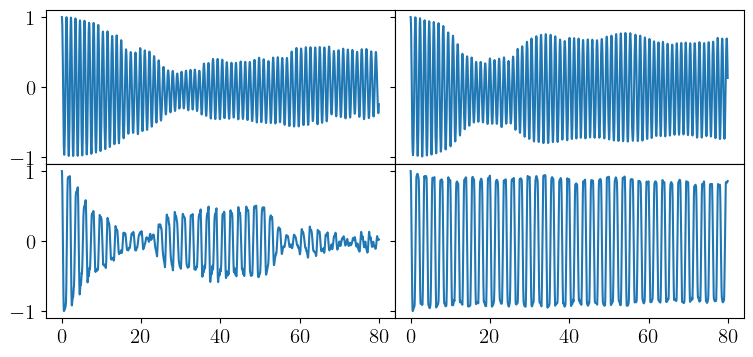

CPU times: user 10min 20s, sys: 1.23 s, total: 10min 21s
Wall time: 10min 20s


In [16]:
%%time
from qutip import *
import numpy as np
from scipy import signal
import random
import matplotlib.pyplot as plt
from scipy.special import jn_zeros,jv
from itertools import combinations
from multiprocessing import Pool
from tqdm import tqdm

#from functions import *

freezing_pts = jn_zeros(0, 5)
plt.rcParams.update({"figure.figsize": (9, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})

N = 8
N1= int(N/2)
N2= N-N1
ea, eb = 0.03, 0.9

lamb = 0.0
lambd_x = lamb
lambd_y = lamb

ft = 10    # fontsize
beta = 0.0

opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

h0 = 0.0
ws = [0.05, 20.0]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
sx,sy,sz = sigmax(), sigmay(), sigmaz()

spinposition_A = 1

i = spinposition_A
id = qeye(2**i)    
dim12 = N-1-i
id1 = qeye(2**dim12)
sz_o = Qobj(tensor(id,tensor(sz,id1)).full())

for l,w in enumerate(ws):
    T = 2 * np.pi/w
    times = np.linspace(0,80  * T, 2000, endpoint=False)
    g = np.pi/T
    Jvalue = 0.2/T
    hs = [ w/4 * 3.5, freezing_pts[0] * w/4 ]
    
    for k,h in enumerate(hs):
        print('w=',w,'h=',h)
        params = {'h0':0, 'h':h, 'omega':omega, 'N':N,'N1':N1,\
                   'opts':opts, 'sz_o':sz_o, 'lambd_x':lambd_x,\
                   'lambd_y':lambd_y, 'Jvalue':Jvalue,'beta':beta,\
                   'g':g,'ea':ea,'eb':eb, 'times':times}
        lbl = r"$H_{exact}$  " + fr"\mathcal{{J}}_(4h/\omega) = {jv(0,(4*h/w)):1.1f}" 
        
        data = run_exact(params)
        
        szav = data[0]
        axs[l][k].plot(times/T, szav)
        
    #plt.legend()
plt.show()